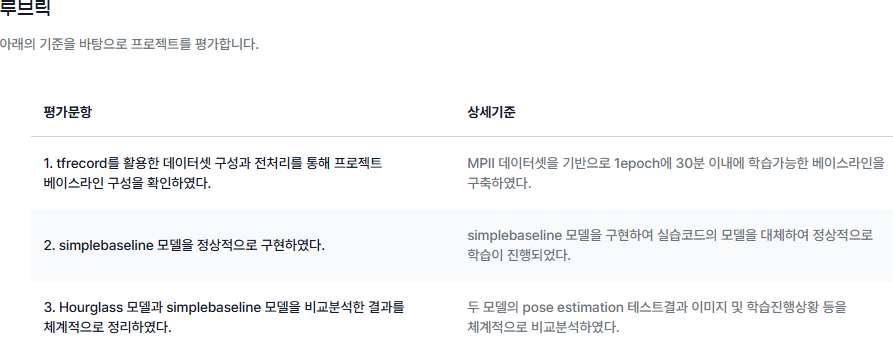

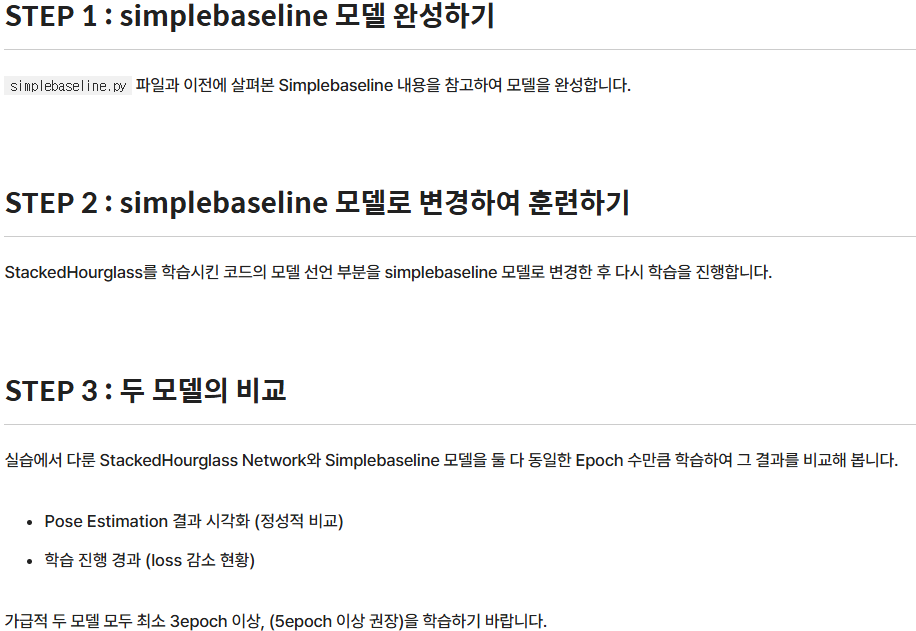

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [2]:
# TRAIN_JSON 파일을 열어 파일 객체를 train_json으로 설정합니다.
with open(TRAIN_JSON) as train_json:
    # train_json 파일에서 JSON 데이터를 로드하여 train_annos에 저장합니다.
    train_annos = json.load(train_json)
    
    # train_annos의 첫 번째 요소를 JSON 포맷으로 변환하고, 가독성을 위해 들여쓰기(indent)를 2칸으로 설정합니다.
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    
    # 포맷된 JSON 데이터를 출력하여 파일 내 첫 번째 JSON 항목을 확인합니다.
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
def parse_one_annotation(anno, image_dir):
    # 'image' 키에서 파일 이름을 가져옵니다.
    filename = anno['image']
    
    # 관절 좌표를 저장합니다.
    joints = anno['joints']
    
    # 관절 가시성 정보를 저장합니다.
    joints_visibility = anno['joints_vis']
    
    # 주석 정보를 포함한 딕셔너리를 생성합니다.
    annotation = {
        'filename': filename,  # 이미지 파일 이름
        'filepath': os.path.join(image_dir, filename),  # 이미지 파일 경로
        'joints_visibility': joints_visibility,  # 관절 가시성 정보
        'joints': joints,  # 관절 좌표 정보
        'center': anno['center'],  # 이미지 내 중심 좌표
        'scale': anno['scale']  # 이미지의 스케일 정보
    }
    
    # 완성된 annotation 딕셔너리를 반환합니다.
    return annotation

In [4]:
# TRAIN_JSON 파일을 열고, 파일 객체를 train_json으로 설정합니다.
with open(TRAIN_JSON) as train_json:
    # train_json 파일에서 JSON 데이터를 로드하여 train_annos에 저장합니다.
    train_annos = json.load(train_json)
    
    # train_annos의 첫 번째 항목을 parse_one_annotation 함수를 통해 파싱하고, 결과를 test 변수에 저장합니다.
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    
    # 파싱된 결과를 출력하여 첫 번째 주석 항목의 구조와 내용을 확인합니다.
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
def generate_tfexample(anno):
    
    # byte 인코딩을 위한 함수: TensorFlow의 Feature 객체에 bytes 데이터를 추가할 때 사용
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()  # TensorFlow 상수를 numpy 배열로 변환
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))  # bytes 리스트로 변환하여 반환

    # 주석에서 파일 이름과 파일 경로를 가져옵니다.
    filename = anno['filename']
    filepath = anno['filepath']
    
    # 이미지 파일을 바이너리 모드로 열어 내용을 읽습니다.
    with open(filepath, 'rb') as image_file:
        content = image_file.read()
    
    # 이미지 객체를 열어 포맷과 색상 모드를 확인
    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':  # JPEG 포맷 및 RGB 모드가 아닐 경우 변환 수행
        image_rgb = image.convert('RGB')  # RGB 모드로 변환
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)  # JPEG 포맷으로 저장하여 content에 추가
            content = output.getvalue()
    
    # 이미지의 너비, 높이 및 색상 깊이를 설정합니다.
    width, height = image.size
    depth = 3  # RGB 이미지이므로 깊이는 3입니다.
    
    # 중심 좌표와 스케일 값을 가져옵니다.
    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']
    
    # 관절 좌표를 x, y 리스트에 추가
    x = [int(joint[0]) if joint[0] >= 0 else int(joint[0]) for joint in anno['joints']]
    y = [int(joint[1]) if joint[1] >= 0 else int(joint[0]) for joint in anno['joints']]
    
    # 관절 가시성 정보 변환: 0이면 숨김(0), 나머지 값은 가시(2)
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]
    
    # 특징 딕셔너리를 생성하여 각 데이터를 Feature 객체로 변환
    feature = {
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth': tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x': tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y': tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale': tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v': tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded': _bytes_feature(content),  # 이미지 파일의 인코딩된 바이너리 데이터
        'image/filename': _bytes_feature(filename.encode())  # 파일 이름을 바이트 형태로 변환
    }
    
    # TFRecord의 Example 객체로 반환하여 저장 가능한 형식으로 변환
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [6]:
def chunkify(l, n):
    # 리스트 l의 길이를 n으로 나눈 몫을 계산하여 각 청크의 크기로 설정합니다.
    size = len(l) // n
    start = 0  # 각 청크의 시작 인덱스
    results = []  # 청크를 저장할 리스트

    # n개의 청크로 나누기 위해 반복문 실행
    for i in range(n):
        # 리스트의 일부분 (start에서 start + size까지)을 청크로 잘라 results에 추가
        results.append(l[start:start + size])
        start += size  # 다음 청크의 시작 인덱스 갱신

    # n개의 청크가 담긴 리스트를 반환합니다.
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64)  # 길이가 1000인 리스트를 64개 청크로 나눕니다.
print(test_chunks)  # 각 청크의 내용을 출력합니다.
print(len(test_chunks))  # 생성된 청크의 총 개수를 출력합니다.
print(len(test_chunks[0]))  # 각 청크의 길이를 확인하기 위해 첫 번째 청크의 길이를 출력합니다.

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
# 데코레이터로 병렬 실행 가능
def build_single_tfrecord(chunk, path):
    # TFRecord 파일 생성을 시작하는 메시지를 출력합니다.
    print('start to build tf records for ' + path)
    
    # TFRecordWriter를 사용하여 주어진 경로에 TFRecord 파일을 생성합니다.
    with tf.io.TFRecordWriter(path) as writer:
        # 청크 내 각 주석(annotation)을 순회하며 TFRecord에 기록합니다.
        for anno in chunk:
            tf_example = generate_tfexample(anno)  # 주석 데이터를 TFRecord 예제로 변환
            writer.write(tf_example.SerializeToString())  # 변환한 예제를 직렬화하여 파일에 작성

    # TFRecord 파일 생성이 완료되었음을 알리는 메시지를 출력합니다.
    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    # 전체 주석 데이터를 주어진 TFRecord 파일 개수만큼의 청크로 나눕니다.
    chunks = chunkify(annotations, total_shards)
    
    # build_single_tfrecord 작업을 Ray로 병렬 실행하기 위해 미래 객체(future)를 생성합니다.
    futures = [
        build_single_tfrecord.remote(
            chunk,
            '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,  # TFRecord 파일이 저장될 경로
                split,  # 데이터의 분할 이름 (예: train, val)
                str(i + 1).zfill(4),  # 현재 청크 인덱스 (네 자리수로 표현)
                str(total_shards).zfill(4)  # 전체 청크 개수 (네 자리수로 표현)
            )
        ) for i, chunk in enumerate(chunks)
    ]
    
    # Ray를 통해 비동기로 실행된 작업이 모두 완료될 때까지 대기합니다.
    ray.get(futures)

In [10]:
# 학습 및 검증 데이터를 저장할 TFRecord 파일 수를 설정합니다.
num_train_shards = 64
num_val_shards = 8

# Ray를 초기화하여 병렬 작업을 위한 환경을 설정합니다.
ray.init()

print('Start to parse annotations.')  # 주석 데이터 파싱 시작을 알리는 메시지

# TFRecord 파일이 저장될 디렉토리가 없을 경우 생성합니다.
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

# 학습 주석 파일을 열고 파싱합니다.
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)  # JSON 파일을 로드하여 train_annos에 저장
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)  # 각 주석을 파싱하여 리스트에 저장
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])  # 첫 번째 학습 주석을 출력하여 확인

# 검증 주석 파일을 열고 파싱합니다.
with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)  # JSON 파일을 로드하여 val_annos에 저장
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)  # 각 주석을 파싱하여 리스트에 저장
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])  # 첫 번째 검증 주석을 출력하여 확인

print('Start to build TF Records.')  # TFRecord 생성 시작을 알리는 메시지

# 학습 주석을 num_train_shards 수만큼 나누어 병렬로 TFRecord 파일을 생성합니다.
build_tf_records(train_annotations, num_train_shards, 'train')

# 검증 주석을 num_val_shards 수만큼 나누어 병렬로 TFRecord 파일을 생성합니다.
build_tf_records(val_annotations, num_val_shards, 'val')

# 최종 완료 메시지와 함께 생성된 주석 개수를 출력합니다.
print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2024-11-05 01:32:09,140	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.94gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

In [11]:
class Preprocessor(object):
    def __init__(self, image_shape=(256, 256, 3), heatmap_shape=(64, 64, 16), is_train=False):
        # 전처리 클래스 초기화
        self.is_train = is_train  # 학습 모드 여부 설정
        self.image_shape = image_shape  # 출력 이미지 형태 설정
        self.heatmap_shape = heatmap_shape  # 출력 히트맵 형태 설정

    def __call__(self, example):
        # TFRecord에서 하나의 example을 파싱하여 이미지와 히트맵을 생성합니다.
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])  # JPEG 형식의 이미지를 디코딩

        # 학습 중일 때는 랜덤 여백을 사용해 관심 영역을 잘라내고 이미지 크기를 조정합니다.
        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            # 평가 모드에서는 고정된 여백을 사용
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        # 이미지 값을 -1에서 1 사이로 정규화합니다.
        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps  # 전처리된 이미지와 히트맵 반환

    def crop_roi(self, image, features, margin=0.2):
        # 이미지의 관심 영역(ROI)을 자르는 메서드
        img_shape = tf.shape(image)
        img_height, img_width = img_shape[0], img_shape[1]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        body_height = features['image/object/scale'] * 200.0

        # 유효한 키포인트 좌표만 사용하여 ROI 설정
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

        # ROI 영역 결정
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)

        # 여백을 추가해 정사각형 박스를 만듦
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

        # ROI가 이미지 경계를 넘지 않도록 조정
        effective_xmin = tf.math.maximum(0, xmin)
        effective_ymin = tf.math.maximum(0, ymin)
        effective_xmax = tf.math.minimum(xmax, img_width)
        effective_ymax = tf.math.minimum(ymax, img_height)

        # 이미지를 ROI로 자르고 새로운 크기를 계산
        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height, new_width = new_shape[0], new_shape[1]

        # 키포인트 좌표를 ROI 기준으로 변환하여 반환
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

        return image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        # 특정 위치에서 2D 가우시안 패치를 생성하는 메서드
        heatmap = tf.zeros((height, width))

        # 가우시안 범위를 계산
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap  # 범위 밖일 경우 빈 히트맵 반환

        # 가우시안 패치 생성
        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, size), tf.range(0, size), indexing='xy')
        center_x, center_y = size // 2, size // 2

        # 가우시안 패치 생성
        gaussian_patch = tf.cast(
            tf.math.exp(-(tf.square(x - center_x) + tf.square(y - center_y)) / (2 * tf.square(sigma))) * scale,
            dtype=tf.float32
        )

        # 가우시안 패치를 히트맵에 추가
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1

        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        # 키포인트 위치에 가우시안 히트맵을 생성
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, size=num_heatmap)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # 최종 히트맵 형태를 (64, 64, 16)으로 변환

        return heatmaps

    def parse_tfexample(self, example):
        # TFRecord 예제를 파싱하여 딕셔너리 형태로 반환
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example, image_feature_description)

In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add

def conv_bn_relu(inputs, filters, kernel_size, strides=1, padding='same'):
    # Conv-BN-ReLU 패턴을 하나의 함수로 묶어 반복되는 패턴을 줄임
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
               padding=padding, kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    return ReLU()(x)

def BottleneckBlock(inputs, filters, strides=1, downsample=False):
    # 다운샘플링이 필요한 경우 identity에 1x1 Conv2D 적용
    identity = Conv2D(filters, 1, strides=strides, padding='same',
                      kernel_initializer='he_normal')(inputs) if downsample else inputs

    # Bottleneck 구조의 Conv-BN-ReLU 시퀀스를 간결화
    x = conv_bn_relu(inputs, filters // 2, kernel_size=1)
    x = conv_bn_relu(x, filters // 2, kernel_size=3, strides=strides)
    x = Conv2D(filters=filters, kernel_size=1, strides=1,
               padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)

    # 입력과 변형된 텐서를 더하여 잔여 연결 생성
    return ReLU()(Add()([identity, x]))

(build_single_tfrecord pid=151) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


In [13]:
def HourglassModule(inputs, order, filters, num_residual):
    # 첫 번째 상위 경로 (up1): BottleneckBlock을 적용하여 잔여 연결을 생성
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):  # 지정된 수만큼 BottleneckBlock을 반복 적용
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # 첫 번째 하위 경로 (low1): MaxPooling으로 크기를 절반으로 줄임
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):  # 지정된 수만큼 BottleneckBlock을 적용하여 특징 추출
        low1 = BottleneckBlock(low1, filters, downsample=False)

    # 두 번째 하위 경로 (low2): 재귀적으로 HourglassModule을 호출하여 깊이를 늘리거나, 마지막 수준에 도달할 경우 BottleneckBlock 적용
    low2 = low1
    if order > 1:
        # 재귀적으로 Hourglass 모듈을 호출하여 추가적인 특징 추출
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        # 마지막 수준의 경우 지정된 수만큼 BottleneckBlock을 적용
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    # 세 번째 하위 경로 (low3): low2에 대해 BottleneckBlock을 다시 적용하여 특징을 증대
    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    # 업샘플링 경로 (up2): 상위 경로와 크기를 맞추기 위해 UpSampling 수행
    up2 = UpSampling2D(size=2)(low3)

    # 상위 경로 (up1)와 업샘플링 경로 (up2)를 더해 최종 출력 생성
    return up2 + up1

In [14]:
def LinearLayer(inputs, filters):
    # Conv2D 레이어: 1x1 커널을 사용하여 채널 수를 지정된 filters로 변경
    x = Conv2D(
        filters=filters,              # 출력 채널 수
        kernel_size=1,                # 커널 크기를 1x1로 설정하여 공간 차원에 영향을 주지 않음
        strides=1,                    # strides를 1로 설정하여 입력 크기를 그대로 유지
        padding='same',               # 출력 크기가 입력과 동일하도록 padding 설정
        kernel_initializer='he_normal' # He 초기화 방법을 사용해 가중치를 초기화
    )(inputs)

    # Batch Normalization 레이어: 학습을 안정화하고 수렴 속도를 향상시키기 위해 사용
    x = BatchNormalization(momentum=0.9)(x)

    # ReLU 활성화 함수: 비선형성을 추가하여 모델이 복잡한 표현을 학습할 수 있도록 함
    x = ReLU()(x)

    return x  # 변형된 텐서를 반환

In [15]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3),  # 입력 이미지 크기
        num_stack=4,                # Hourglass 모듈의 스택 수
        num_residual=1,             # 각 Hourglass 모듈 내의 잔여 연결(BottleneckBlock) 수
        num_heatmap=16):            # 생성할 히트맵 수 (예: 키포인트 수)
    
    # 입력 텐서 정의
    inputs = Input(shape=input_shape)

    # 초기 특징 추출 Conv 레이어
    x = Conv2D(
        filters=64,                  # 64개의 필터 사용
        kernel_size=7,               # 7x7 커널 크기
        strides=2,                   # 2로 strides하여 다운샘플링
        padding='same',              # 입력과 출력 크기를 동일하게 유지
        kernel_initializer='he_normal' # He 초기화로 가중치 초기화
    )(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)

    # BottleneckBlock을 통해 채널 수를 128로 증가하고 다운샘플링 적용
    x = BottleneckBlock(x, 128, downsample=True)

    # MaxPooling을 사용하여 크기를 반으로 줄임
    x = MaxPool2D(pool_size=2, strides=2)(x)

    # 추가 BottleneckBlock을 통해 특징 추출
    x = BottleneckBlock(x, 128, downsample=False)

    # 채널 수를 256으로 증가시키기 위해 다운샘플링을 적용하는 BottleneckBlock
    x = BottleneckBlock(x, 256, downsample=True)

    # 출력 히트맵을 담을 리스트 초기화
    ys = []
    
    # 지정된 수(num_stack)만큼 Hourglass 모듈을 스택
    for i in range(num_stack):
        # Hourglass 모듈을 적용하여 입력을 256 필터로 특징 추출
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)

        # 추가 BottleneckBlock을 num_residual 수만큼 적용
        for _ in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # LinearLayer를 사용하여 출력 크기를 256으로 변환
        x = LinearLayer(x, 256)

        # 히트맵 생성을 위한 1x1 Conv 레이어 적용
        y = Conv2D(
            filters=num_heatmap,      # 히트맵의 채널 수를 num_heatmap으로 설정
            kernel_size=1,            # 1x1 커널 사용
            strides=1,                # strides 1로 설정해 크기 유지
            padding='same',           # 출력 크기를 동일하게 유지
            kernel_initializer='he_normal' # He 초기화 사용
        )(x)
        
        # 생성된 히트맵을 리스트에 추가
        ys.append(y)

        # 마지막 Hourglass 모듈 이전까지는 중간 결과를 다음 모듈로 전달
        if i < num_stack - 1:
            # 두 개의 1x1 Conv 레이어를 통해 중간 출력을 재구성
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            
            # 중간 결과를 더하여 다음 Hourglass 모듈로 전달
            x = Add()([y_intermediate_1, y_intermediate_2])

    # 모델 정의: 입력 텐서와 스택된 Hourglass 모듈의 출력 리스트(ys)를 반환
    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [16]:
class Trainer(object):
    def __init__(self,
                 model,                 # 학습할 모델
                 epochs,                # 전체 학습 에포크 수
                 global_batch_size,     # 전역 배치 크기
                 strategy,              # 분산 전략
                 initial_learning_rate):# 초기 학습률
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size

        # 손실 함수로 MeanSquaredError를 사용하고, 각 예제를 개별적으로 처리할 수 있도록 설정
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        
        # Adam 옵티마이저를 초기 학습률로 설정
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf  # 마지막 검증 손실 초기값 설정
        self.lowest_val_loss = math.inf  # 가장 낮은 검증 손실을 추적하기 위한 변수
        self.patience_count = 0  # 학습률 감소 전 patience 카운트
        self.max_patience = 10   # 학습률 감소를 위한 patience 한계
        self.best_model = None   # 최적 모델을 저장할 변수

    def lr_decay(self):
        # patience가 한계를 초과하면 학습률 감소
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0  # 최적 검증 손실을 유지하는 경우 patience를 초기화
        self.patience_count += 1  # patience 카운트를 증가

        # 옵티마이저의 학습률 갱신
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        # 특정 에포크에서 학습률을 줄이기 위한 메서드
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        # 손실 계산 메서드
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            # MSE 손실을 계산하고 가중치를 적용
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        # 학습 스텝 정의
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        # 손실에 따른 기울기 계산 및 적용
        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        # 검증 스텝 정의
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        # 모델 학습 루프 시작
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                # 각 배치에서 train_step을 호출하여 학습 수행
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            # 분산 검증 수행
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1  # NaN 값이 나온 배치를 제외

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            # 학습률 감소 적용
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            # 학습 에포크 수행
            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            # 검증 에포크 수행
            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # 최적 검증 손실 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        # 최적 모델 저장
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [18]:
class Trainer(object):
    def __init__(self,
                 model,                 # 학습할 모델
                 epochs,                # 전체 학습 에포크 수
                 global_batch_size,     # 전역 배치 크기
                 strategy,              # 분산 전략
                 initial_learning_rate):# 초기 학습률
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size

        # 손실 함수로 MeanSquaredError를 사용하고, 각 예제를 개별적으로 처리할 수 있도록 설정
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        
        # Adam 옵티마이저를 초기 학습률로 설정
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf  # 마지막 검증 손실 초기값 설정
        self.lowest_val_loss = math.inf  # 가장 낮은 검증 손실을 추적하기 위한 변수
        self.patience_count = 0  # 학습률 감소 전 patience 카운트
        self.max_patience = 10   # 학습률 감소를 위한 patience 한계
        self.best_model = None   # 최적 모델을 저장할 변수

    def lr_decay(self):
        # patience가 한계를 초과하면 학습률 감소
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0  # 최적 검증 손실을 유지하는 경우 patience를 초기화
        self.patience_count += 1  # patience 카운트를 증가

        # 옵티마이저의 학습률 갱신
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        # 특정 에포크에서 학습률을 줄이기 위한 메서드
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        # 손실 계산 메서드
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            # MSE 손실을 계산하고 가중치를 적용
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        # 학습 스텝 정의
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        # 손실에 따른 기울기 계산 및 적용
        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        # 검증 스텝 정의
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        # 모델 학습 루프 시작
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                # 각 배치에서 train_step을 호출하여 학습 수행
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            # 분산 검증 수행
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1  # NaN 값이 나온 배치를 제외

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            # 학습률 감소 적용
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            # 학습 에포크 수행
            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            # 검증 에포크 수행
            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # 최적 검증 손실 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        # 최적 모델 저장
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [19]:
IMAGE_SHAPE = (256, 256, 3)  # 입력 이미지의 크기 (높이, 너비, 채널)
HEATMAP_SIZE = (64, 64)      # 히트맵 크기 (높이, 너비)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    # Preprocessor 클래스 초기화: 이미지 크기와 히트맵 크기, 학습 여부 설정
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    # TFRecord 파일 경로를 가져와 데이터셋을 생성
    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)  # TFRecordDataset을 사용하여 데이터셋 로드
    
    # 각 TFRecord 예제를 Preprocessor를 사용해 전처리
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # AUTOTUNE을 사용해 병렬 처리

    # 학습 모드인 경우 데이터셋을 셔플링하여 학습 순서를 무작위로 섞음
    if is_train:
        dataset = dataset.shuffle(batch_size)

    # 배치 구성 및 Prefetch 적용: 학습/추론을 위한 배치와 데이터 로딩의 병렬 처리 설정
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # AUTOTUNE으로 프리페칭 최적화

    return dataset  # 구성된 tf.data.Dataset 반환

In [20]:
# 학습된 모델 가중치 파일의 경로 설정
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

# Stacked Hourglass 네트워크 모델 초기화: 입력 이미지 크기, 스택 수, 잔여 연결 수 설정
model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)

# 지정된 경로의 가중치 파일을 모델에 로드하여 이전 학습 결과를 불러옴
model.load_weights(WEIGHTS_PATH)

# 이전 학습 코드 블록을 통해 학습한 후 해당 모델을 사용할 경우, 아래 주석 처리된 코드 사용
# model.load_weights(best_model_file)  # train 함수에서 반환된 최적 모델 파일 경로를 불러오기

ValueError: axes don't match array

In [21]:
import tensorflow as tf
from tensorflow import keras

# ResNet-50 backbone
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

# Deconvolution layer 구성 함수
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

# Deconvolution layers
upconv = _make_deconv_layer(3)

# 마지막 출력 레이어
final_layer = tf.keras.layers.Conv2D(17, kernel_size=(1,1), padding='same')

# SimpleBaseline 모델 정의
def Simplebaseline(input_shape=(192, 256, 3)):
    inputs = keras.Input(shape=input_shape)
    x = resnet(inputs, training=False)
    x = upconv(x)
    out = final_layer(x)
    model = keras.Model(inputs, out, name='simple_baseline')
    return model

# 모델 생성 및 요약 출력
model = Simplebaseline()
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 48, 64, 256)       10489600  
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 48, 64, 17)        4369      
Total params: 34,081,681
Trainable params: 34,027,025
Non-trainable params: 54,656
_________________________________________________________________


In [22]:
# 학습 및 검증 TFRecord 파일 경로 설정
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')  # TFRECORD_PATH 내 모든 'train' 파일을 포함하는 경로 패턴
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')      # TFRECORD_PATH 내 모든 'val' 파일을 포함하는 경로 패턴

# 학습 파라미터 설정
epochs = 2               # 총 학습 에포크 수
batch_size = 16          # GPU당 배치 크기
num_heatmap = 16         # 출력 히트맵 개수 (예: 키포인트 수)
learning_rate = 0.0007   # 초기 학습률 설정

# train 함수를 호출하여 학습을 시작하고, 최적 모델 파일 경로를 반환받음
best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

NameError: name 'train' is not defined

## 회고

* 결석해서 완성하지 못했는데... 제출은 해야해서.. 여기서 마무리합니다..ㅠㅠ
* simplebaseline 모델을 만들어보고 학습도 하면 좋을 것 같지만, 현재 진행중인 노드와 병행하기가 어려웠습니다.ㅠㅠ